In [1]:
# Load all packages
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
     
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import neptune.new as neptune
import random
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

In [2]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f)

0


In [3]:
# Get the APi key, from outside the git folder.
file = open("../API-key.txt", "r")
key = file.readlines()

run = neptune.init(
    project="Facemask-project/Facemask",
    api_token=key[0])

# Choose the device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

https://app.neptune.ai/Facemask-project/Facemask/e/FAC-89
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
run['namespace/Run_name'] = "large_new_mask_Big_batch"
run['sys/tags'].add(['size_125', "flip", "new_mask"])

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Create the data loader. This data
class DataLoader():
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None, transforms = None,
                 random_perspective = None, flip = False, blur = False, new_mask = False, bright = False):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.transforms = transforms
        self.fileNames = os.listdir(img_dir)
        self.random_perspective = random_perspective
        self.flip = flip
        self.blur = blur
        self.new_mask = new_mask
        self.bright = bright
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        target_image = read_image(img_path2)
        image = image.clone().detach().float()
        target_image = target_image.clone().detach().float()
        if self.new_mask:
            if random.uniform(0,1) > 0.5:
                image = new_mask(image, target_image)
        if self.transform:
            if random.uniform(0,1) > 0.9:
                image = self.transform(image)
                
        if self.transforms:
            image = self.transforms(image)
            target_image = self.transforms(target_image)
        if self.bright:
            if random.uniform(0,1) > 0.5:
                adjust = random.uniform(0.3, 1.8)
                image = torchvision.transforms.functional.adjust_brightness(image, adjust)
                target_image = torchvision.transforms.functional.adjust_brightness(target_image, adjust)
        if self.flip:
            if random.uniform(0,1) > 0.5:
                image = torchvision.transforms.functional.hflip(image)
                target_image = torchvision.transforms.functional.hflip(target_image)
        if self.random_perspective:
            if random.uniform(0,1) > 0.5:
                scale = random.uniform(0,0.4)
                startpoints, endpoints = transforms.RandomPerspective().get_params(50,50, distortion_scale=scale)
                image = torchvision.transforms.functional.perspective(image, startpoints, endpoints)
                target_image  = torchvision.transforms.functional.perspective(target_image, startpoints, endpoints)
        
        return image, target_image

In [6]:
def new_mask(image, target):
    #Get mask pixels
    old_mask = torch.abs(image - target)
    mask_index = np.where(old_mask != 0, True, False)
    # New mask or random colours
    if random.uniform(0,1) > 0.5:
        image[0, mask_index[0]] = random.uniform(0,255)
        image[1, mask_index[1]] = random.uniform(0,255)
        image[2, mask_index[2]] = random.uniform(0,255)
        return torch.tensor(image)
    else:
        mask_list = os.listdir("facemask")
        mask_number = random.randint(0, len(mask_list)-1)
        mask_image = read_image(os.path.join("facemask", mask_list[mask_number]))
        resize = transforms.Resize((125,125))
        mask_image = resize(mask_image)
        
        # Remove the opacity dimension
        if mask_image.size()[0] == 4:
            mask_image = mask_image[0:3]
        new_image = np.where(old_mask != 0, mask_image, image)
        return torch.tensor(new_image)

In [8]:
#Choose batch_size:
batch_size = 100

#create transformer with mean = 0 and std = 1.
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1))])

#Create the dataset with the dataloader:
traindataset = DataLoader("Data_small/125_with_mask_train", "Data_small/125_without_mask_train",
                     transforms = transformer,
                    random_perspective = False,
                       flip = True,
                       new_mask = True,) 

# split the dataset into test and train set.
testdataset = DataLoader("Data_small/125_with_mask_test", "Data_small/125_without_mask_test",
                     transforms = transformer,
                    random_perspective = None) 

valdataset = DataLoader("Data_small/125_with_mask_val", "Data_small/125_without_mask_val",
                     transforms = transformer,
                    random_perspective = None) 

valloader = torch.utils.data.DataLoader(valdataset, 
                                          batch_size=50, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)

# Set up dataloader and the test
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)

testloader = torch.utils.data.DataLoader(testdataset, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
dataiter = iter(trainloader)


In [9]:
# with auto encoder:

import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2700,2048)

        

        #Encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv11 = nn.Conv2d(8, 16, 5, padding=2) 
        self.conv2 = nn.Conv2d(16, 32, 9, padding=4)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 32, 5, padding=2)
        self.conv5 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv6 = nn.Conv2d(16, 12, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (8,16,16))
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2, padding = 1)
        self.decode_conv1 =  nn.Conv2d(32, 64, 5, padding=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 32 , 2, stride=2,)
        self.t_conv4 = nn.ConvTranspose2d(32, 16, 2, stride=1)
        self.decode_conv2 = nn.Conv2d(16, 8, 5, padding=2)
        self.decode_conv3 = nn.Conv2d(8, 3, 3, padding=1)
        

    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv11(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.unflatten(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.t_conv1(x))

        x = F.relu(self.t_conv2(x))

        x = F.relu(self.decode_conv1(x))

        x = F.relu(self.t_conv3(x))

        x = F.relu(self.t_conv4(x))

        x = F.relu(self.decode_conv2(x))

        x = F.relu(self.decode_conv3(x))

        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.flatlayer(x)
        x = self.decode(x)      
        return x


#Instantiate the model
model = ConvAutoencoder()

#Send the model to the device
model.to(device)
# check the model output is the correct size
model(dataiter.next()[0].to(device)).size()

C:\Users\malth\AppData\Local\Temp/ipykernel_7964/2691885506.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


torch.Size([100, 3, 125, 125])

In [10]:
learning_rate = 0.0001
#Loss function
criterion = torch.nn.MSELoss()

#Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

def update_params():
    run["parameters"] = {"lr": learning_rate,
                         "optim": str(optimizer).split(" ")[0],
                         "loss_function" : "MSE",
                         "Batch_size": batch_size,
                         "image_size": 125
                        }
update_params()

In [22]:
# Trying with a loss function with both MSE and SSIM
def loss_function(output, target):
    criterion = torch.nn.MSELoss()
    mse = criterion(output, target)
    mse = mse/1000
    ssim_loss = 1 - ssim(output, target)
    # see how they match up.
    if random.randint(1,400) == 1:
        print(mse, ssim_loss)
    return mse + ssim_loss

In [64]:
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=5, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)

In [15]:
#Epochs
def train(model, n_epochs = 10, criterion = criterion, optimizer = optimizer, trainloader = trainloader):
    for epoch in range(1, n_epochs+1):
        model.train()
        # monitor training loss
        train_loss = 0.0

        #Training
        for data in trainloader:
            mask_image, image = data
            mask_image , image = mask_image.to(device), image.to(device)
            image = image.clone().detach().float()
            mask_image = mask_image.clone().detach().float()
            optimizer.zero_grad()
            outputs = model(mask_image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
        if (epoch % 1 == 0):
            train_loss += loss.item()
            run["train/loss"].log(train_loss)
            #ssim_acc, mse_loss = validation(model = model)
            #run["train/val_ssim"].log(ssim_acc)
            #run["train/val_mse"].log(mse_loss)
            print('Epoch: {} \tTraining Loss: {:.6f}   Validation accuracy: {}'.format(epoch, train_loss, 2))
        if (epoch % 50 ==0):
            checpoint_name = "checkpoint" + str(epoch)
            save_checkpoint(model, checpoint_name)

In [17]:
model.train()
train(model, n_epochs = 5)


C:\Users\malth\AppData\Local\Temp/ipykernel_7964/2691885506.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


KeyboardInterrupt: 

In [13]:
def validation(model, valloader = valloader):
    model.eval()
    data = valiter.next()
    mask_image, image = data
    mask_image , image = mask_image.to(device), image.to(device)
    image = image.clone().detach().float()
    mask_image = mask_image.clone().detach().float()
    outputs = model(mask_image)
    print(outputs.size())
    loss_ssim = ssim(outputs, image).item()
    print(loss_ssim)
    criterion2 = torch.nn.MSELoss()
    loss_MSE = criterion2(outputs, image).item()
    #t = torch.cuda.get_device_properties(0).total_memory
    #r = torch.cuda.memory_reserved(0)
    #a = torch.cuda.memory_allocated(0)
    #f = r-a  # free inside reserved
    #print("reserved: ", r,  "   allocated:  ", a,   "   Free:   ", f)
    return loss_ssim, loss_MSE

In [8]:

valiter = iter(valloader)
tot_mse = 0
tot_ssim = 0
for i in range(10):
    ssim, mse = validation(model)
    tot_mse += mse
    tot_ssim += ssim

print(tot_mse/10)
print(tot_ssim/10)

torch.Size([50, 3, 125, 125])
0.0016054805601015687
torch.Size([50, 3, 125, 125])


TypeError: 'float' object is not callable

In [ ]:
valiter = iter(valloader)


In [27]:

total_mse = 0
total_ssim = 0
valiter = valiter = iter(valloader)
for i in range(10):
    data = valiter.next()
    mask_image, image = data
    mask_image , image = mask_image.to(device), image.to(device)
    image = torch.tensor(image).float()
    mask_image = mask_image.clone().detach().float()
    outputs = model(mask_image)
    print(outputs.type())
    print(image.type())
    print(outputs.size())
    #loss_ssim1 = ssim(outputs, image)
    #loss_ssim1 = loss_ssim1.item()
    #print(loss_ssim)
    criterion2 = torch.nn.MSELoss()
    loss_MSE = criterion2(outputs, image).item()
    total_mse += loss_MSE
    #total_ssim += loss_ssim


C:\Users\malth\AppData\Local\Temp/ipykernel_12560/4231289198.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()


torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.Size([50, 3, 125, 125])


In [68]:
def print_image(image, model, correct_image, neptune_upload = False):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = image.clone().detach().float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).clone().detach()
        correct = torch.Tensor.cpu(correct_image).clone().detach()
    else:
        output = output.clone().detach()
        correct = correct_image.clone().detach()
        

    ax3.imshow(np.transpose(output.numpy(), (1, 2, 0)).astype('uint8'))
    error = torch.sum(torch.abs(output - correct), 0)
    ax4.imshow(error.numpy().astype('uint8'))
    if neptune_upload:
        run['Test_figures'].upload(fig)
    plt.show()

In [104]:
testdataset = DataLoader("Data_small/125_with_mask_test", "Data_small/125_without_mask_test",
                     transform = transformer,
                    random_perspective = None)
testloader = torch.utils.data.DataLoader(testdataset, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
dataiter = iter(testloader)

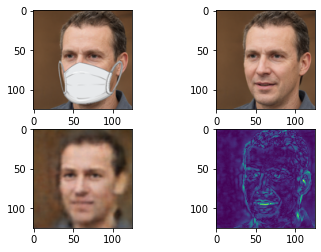

In [249]:
#Test a Model
model.eval()


images, images2 = dataiter.next()
#print_image(images[0], model = model2, correct_image = images2[0])
print_image(images[0], model = model, correct_image = images2[0], neptune_upload = True)

In [260]:
#Save the model as a artifact
def save_checkpoint(model, checkpoint_name):
    checkpoint_name_ext = checkpoint_name + ".pt"
    checkpoints = os.listdir("Checkpoints")
    path = os.path.join("Checkpoints", checkpoint_name_ext)
    try_number = 0
    while (os.path.exists(path)):
        try_number += 1
        checkpoint_name_ext = checkpoint_name + "_" + str(try_number) + ".pt"
        path = os.path.join("Checkpoints", checkpoint_name_ext)
    torch.save(model, path)
    neptune_checkpoint_path = 'model_checkpoints/' + checkpoint_name + "_" + str(try_number)
    run[neptune_checkpoint_path].upload(path)

In [261]:
save_checkpoint(model,"size_125_new_mask5_90_epochs")

InactiveRunException: 

----InactiveRunException----------------------------------------

It seems you are trying to log (or fetch) metadata to a run that was stopped (FAC-88).
What should I do?
    - Resume the run to continue logging to it:
    https://docs.neptune.ai/how-to-guides/neptune-api/resume-run#how-to-resume-run
    - Don't invoke `stop()` on a run that you want to access. If you want to stop monitoring only,
    you can resume a run in read-only mode:
    https://docs.neptune.ai/you-should-know/connection-modes#read-only
You may also want to check the following docs pages:
    - https://docs.neptune.ai/api-reference/run#stop
    - https://docs.neptune.ai/how-to-guides/neptune-api/resume-run#how-to-resume-run
    - https://docs.neptune.ai/you-should-know/connection-modes
Need help?-> https://docs.neptune.ai/getting-started/getting-help


In [6]:
model = torch.load("Checkpoints/size_125_new_mask5_90_epochs_1.pt")

In [251]:
run['sys/tags'].add(["Good"])

In [252]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!


In [93]:

#Create the data loader
class DataLoader_human(Dataset):
    def __init__(self, img_dir, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.fileNames = os.listdir(img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        #image = torchvision.io.ImageReadMode.RGB(img_path)
        try:
            image = read_image(img_path, mode = torchvision.io.image.ImageReadMode.RGB)
        except:
            print("An exception occurred") 
        if image.size()[0] == 4:
            image = image[0:3]
        image = torch.tensor(image).float()
        if self.transform:
            image = self.transform(image)
        return image
    
def print_image_human(image, model):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = torch.tensor(image).float()
    image = image.to(device)
    output = model(image)
    print(ssim(image, output))
    output = torch.squeeze(output,0)

    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).detach().numpy()
    else:
        output = output.detach().numpy()
        

    ax2.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    plt.show()

C:\Users\malth\AppData\Local\Temp/ipykernel_10092/430800945.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()
C:\Users\malth\AppData\Local\Temp/ipykernel_10092/430800945.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()


tensor(0.4943, device='cuda:0', grad_fn=<MeanBackward0>)


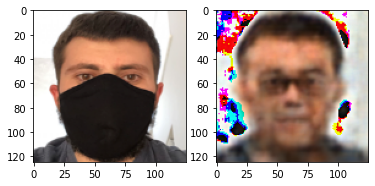

tensor(0.5068, device='cuda:0', grad_fn=<MeanBackward0>)


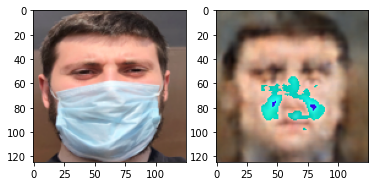

tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward0>)


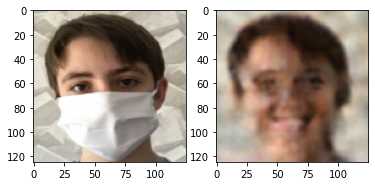

tensor(0.5905, device='cuda:0', grad_fn=<MeanBackward0>)


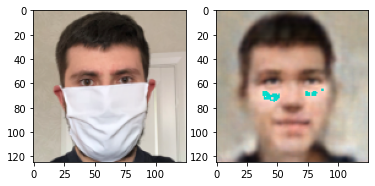

tensor(0.4997, device='cuda:0', grad_fn=<MeanBackward0>)


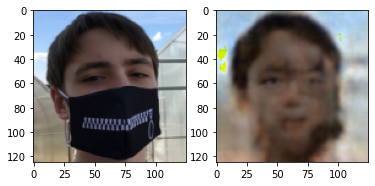

tensor(0.4682, device='cuda:0', grad_fn=<MeanBackward0>)


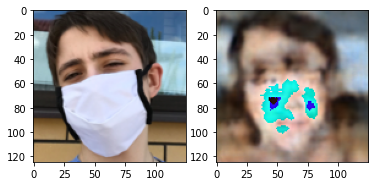

tensor(0.4551, device='cuda:0', grad_fn=<MeanBackward0>)


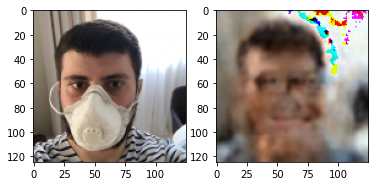

In [99]:

transformer=transforms.Compose([
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                               transforms.Resize((125,125))
                           ])

dataset_human = DataLoader_human("Data_real_human",transform = transformer) 
batch_size = 10
humanloader = torch.utils.data.DataLoader(dataset_human, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0)

dataiter_human = iter(humanloader)
for i in range(7):
    images = dataiter_human.next()
    print_image_human(images[0], model = model)

In [7]:
import torchviz as tviz
batch = next(iter(testloader))
y = model(dataiter.next()[0].to(device)) # Give dummy batch to forward().

tviz.make_dot(y.mean(), params=dict(model.named_parameters()))

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [72]:
import torch
import torchvision.models
import hiddenlayer as hl

In [76]:
hl_graph = hl.build_graph(model, torch.zeros([1, 3, 125, 125]).to(device))

RuntimeError: NYI: Named tensors are not supported with the tracer

In [86]:
import torch.onnx
torch.onnx.export(model, torch.zeros([1, 3, 125, 125]).to(device), "super_resolution.onnx")

RuntimeError: NYI: Named tensors are not supported with the tracer